<a href="https://colab.research.google.com/github/BayezidBostami06/Research-Projects/blob/main/AGN-Mass/Improved-Mass-Estimation-Model-For-Active-Galactic-Nuclei.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic: Variance in mass determination of Active Galactic Nuclei (AGN) with reverberation technique and X-ray method

Author: Md Bayezid Bostami$^{1}$, Hritom Sarkar Oyon$^{2}$

Supervisor: Md Mahmud Un Nobe$^{3}$

[1]   Rajshahi College, Rajshahi

[2]   Adamjee Cantoment Public School and College

[3]   Wayne State University

## Import AGN list

We collected the following data for each AGN from surveys and literature (see references below):

1. Name
2. Redshift ($z$)
3. Full Width Half Maxima of Hydrogen β line ($FWHM$)
4. Luminosity Distance ($d_L$)
5. Mass using X-ray method (M)
6. Mean normalized excess
variance ($σ^2_{nxs}$)
7. Mean time of observation ($T$)

In [ ]:
import pandas as pd
import requests
import io
import re

data_url = 'https://drive.google.com/file/d/1KDsSHKN0ydzbgVfYcyIhO0VSmMtNh41C/view?usp=drive_link'
extract_path = "/content/"

file_id = re.search(r'/d/([a-zA-Z0-9_-]+)', data_url).group(1)
url = f"https://drive.google.com/uc?id={file_id}&export=download"


df = pd.read_csv(io.StringIO(requests.get(url).text))

print(df)

Name = df['Name'].to_list()
z = df['z'].to_numpy()
FWHM = df['FWHM'].to_numpy()
d_L = df['d_L'].to_numpy()
xf = df['XML/FITS'].to_list()
zcorr = df['zcorr'].to_numpy()
mass = df['mass'].to_numpy() * 1e6
sigma2_nxs = df['sigma_nxs^2'].to_numpy()
T = df['T'].to_numpy()

             Name         z  FWHM     d_L XML/FITS  zref  zcorr   mass  \
0         Mrk 335  0.025785  1710   113.3        x     1      1  1.000   
1          I Zw 1  0.061169  1240   275.9        x     2      1  1.550   
2        PHL 1092  0.395388  1790  2163.5        f  SDSS      0  0.400   
3     1H 0707-495  0.040568  1050   180.2        a     4      0  0.340   
4         Mrk 110  0.035517  1760   157.2        f  SDSS      0  1.380   
5         Mrk 142  0.044586  1620   198.7        f  SDSS      0  0.780   
6          Mrk 42  0.024251   670   106.4        f  SDSS      0  0.940   
7        NGC 4051  0.002336  1170    10.1        x     6      0  0.190   
8        NGC 4395  0.001064  1500     4.6        f  SDSS      0  0.062   
9     PG 1211+143  0.080900  1900   370.0        x     7      1  5.300   
10       NGC 4258  0.001538  1200     6.6       a1     8      1  9.450   
11    PG 1244+026  0.048131   830   215.0        f  SDSS      0  0.076   
12   MCG -6-30-15  0.007749  1700    3

In [ ]:
import numpy as np
from astropy import units as u
from astropy.visualization import quantity_support
quantity_support()
from astropy import constants as const

FWHM = FWHM *u.Unit('km s-1')
d_L =   d_L *u.Mpc
mass = mass*u.M_sun
n = len(Name)

## Data Processing



### Import

We collected spectra of each AGN from either NASA/IPAC Extragalactic Database or Sloan Digital Sky Survey (SDSS). We selected the spectra with lowest available resolution between the wavelength range (4750, 5250) Å in source frame.

In [ ]:
import zipfile
import os
import re

spectra_url = "https://drive.google.com/file/d/10HKER9aOPdQUqsRC3RhB0S8McHfXMpEG&export=download"
extract_path = "/content/"

file_id = re.search(r'/d/([a-zA-Z0-9_-]+)', spectra_url).group(1)
url = f"https://drive.google.com/uc?id={file_id}&export=download"

response = requests.get(url)
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
  zip_ref.extractall(extract_path)

In [ ]:
from astropy.io.votable import parse
from astropy.table import Table
from astropy.io import fits
from astropy.io import ascii


lambda_1 = [[]] * n
F_1 = [[]] * n

lambda_0 = [[]] * n
F_0 = [[]] * n
L_0 = [[]] * n

for i in np.arange(n):
  #For NED XML:
  if xf[i] == 'x':
    votable = parse('./Spectra/'+Name[i]+'.xml')
    table = votable.get_first_table().to_table(use_names_over_ids=True)
    data = table.to_pandas()

    lambda_ = const.c.to(u.Unit('AA Hz')) / (np.array(data.Frequency) * u.Hz)
    F_ = (np.array(data.Flux) * u.Unit('W m-2 Hz-1')) * const.c.to(u.Unit('AA Hz')) / (lambda_**2)


  #For SDSS FITS:
  if xf[i] == 'f':
    table = Table.read('./Spectra/'+Name[i]+'.fits', hdu="COADD")
    data = table.to_pandas()

    lambda_ = pow(10, np.array(data.loglam)) *u.AA
    F_ = (np.array(data.flux) * 1.0e-17 * u.Unit('erg cm-2 s-1 AA-1')).to(u.Unit('W m-2 AA-1'))


  #For NED ASCII:
  if xf[i] == 'a':
    table = ascii.read('./Spectra/'+Name[i]+'.txt')
    data = table.to_pandas()

    lambda_ = np.array(data['lambda']) *u.AA
    F_ = (np.array(data['count']) *u.Unit('m-2 s-1 AA-1') * const.h * const.c /lambda_).to(u.Unit('W m-2 AA-1'))

  if xf[i] == 'a1':
    table = ascii.read('./Spectra/'+Name[i]+'.txt')
    data = table.to_pandas()

    lambda_ = np.array(data['lambda']) *u.AA
    F_ = (np.array(data['flux']) *1.0e-15*u.Unit('erg cm-2 s-1 AA-1')).to(u.Unit('W m-2 AA-1'))


    for j in np.arange(len(lambda_)-1, 0, -1):
      if F_[j] <= 0.5e-14*u.Unit('erg cm-2 s-1 AA-1'):
        lambda_ = np.delete(lambda_, j)
        F_ = np.delete(F_, j)

  lambda_1[i] = lambda_
  F_1[i] = F_

### Convert to Source Frame

We corrected the spectra for redshift. We determined if the spectra was already corrected by matching the Hydrogen β and OIII lines with the collected spectra. In such cases, we determined the observed spectra for the spectra which were already corrected by the survey.

$\lambda_0 = \frac{\lambda_1}{(1+z)}$

$F_0 = F_1\cdot(1+z)$

Then, we determined luminosity function of the galaxy using the following formula:

$L_0 = F_0 \cdot 4 \pi d_L^2 \cdot \lambda_0$

In [ ]:
for i in np.arange(n):
  if zcorr[i] == 0:
    lambda_0[i] = lambda_1[i]/(1+z[i])
    F_0[i] = F_1[i]*(1+z[i])
  else:
    lambda_0[i] = lambda_1[i]
    F_0[i] = F_1[i]

    lambda_1[i] = lambda_0[i]*(1+z[i])
    F_1[i] = F_0[i]/(1+z[i])

  L_0[i] = (F_0[i] * 4 * np.pi * d_L[i].to(u.m)**2) *lambda_0[i]

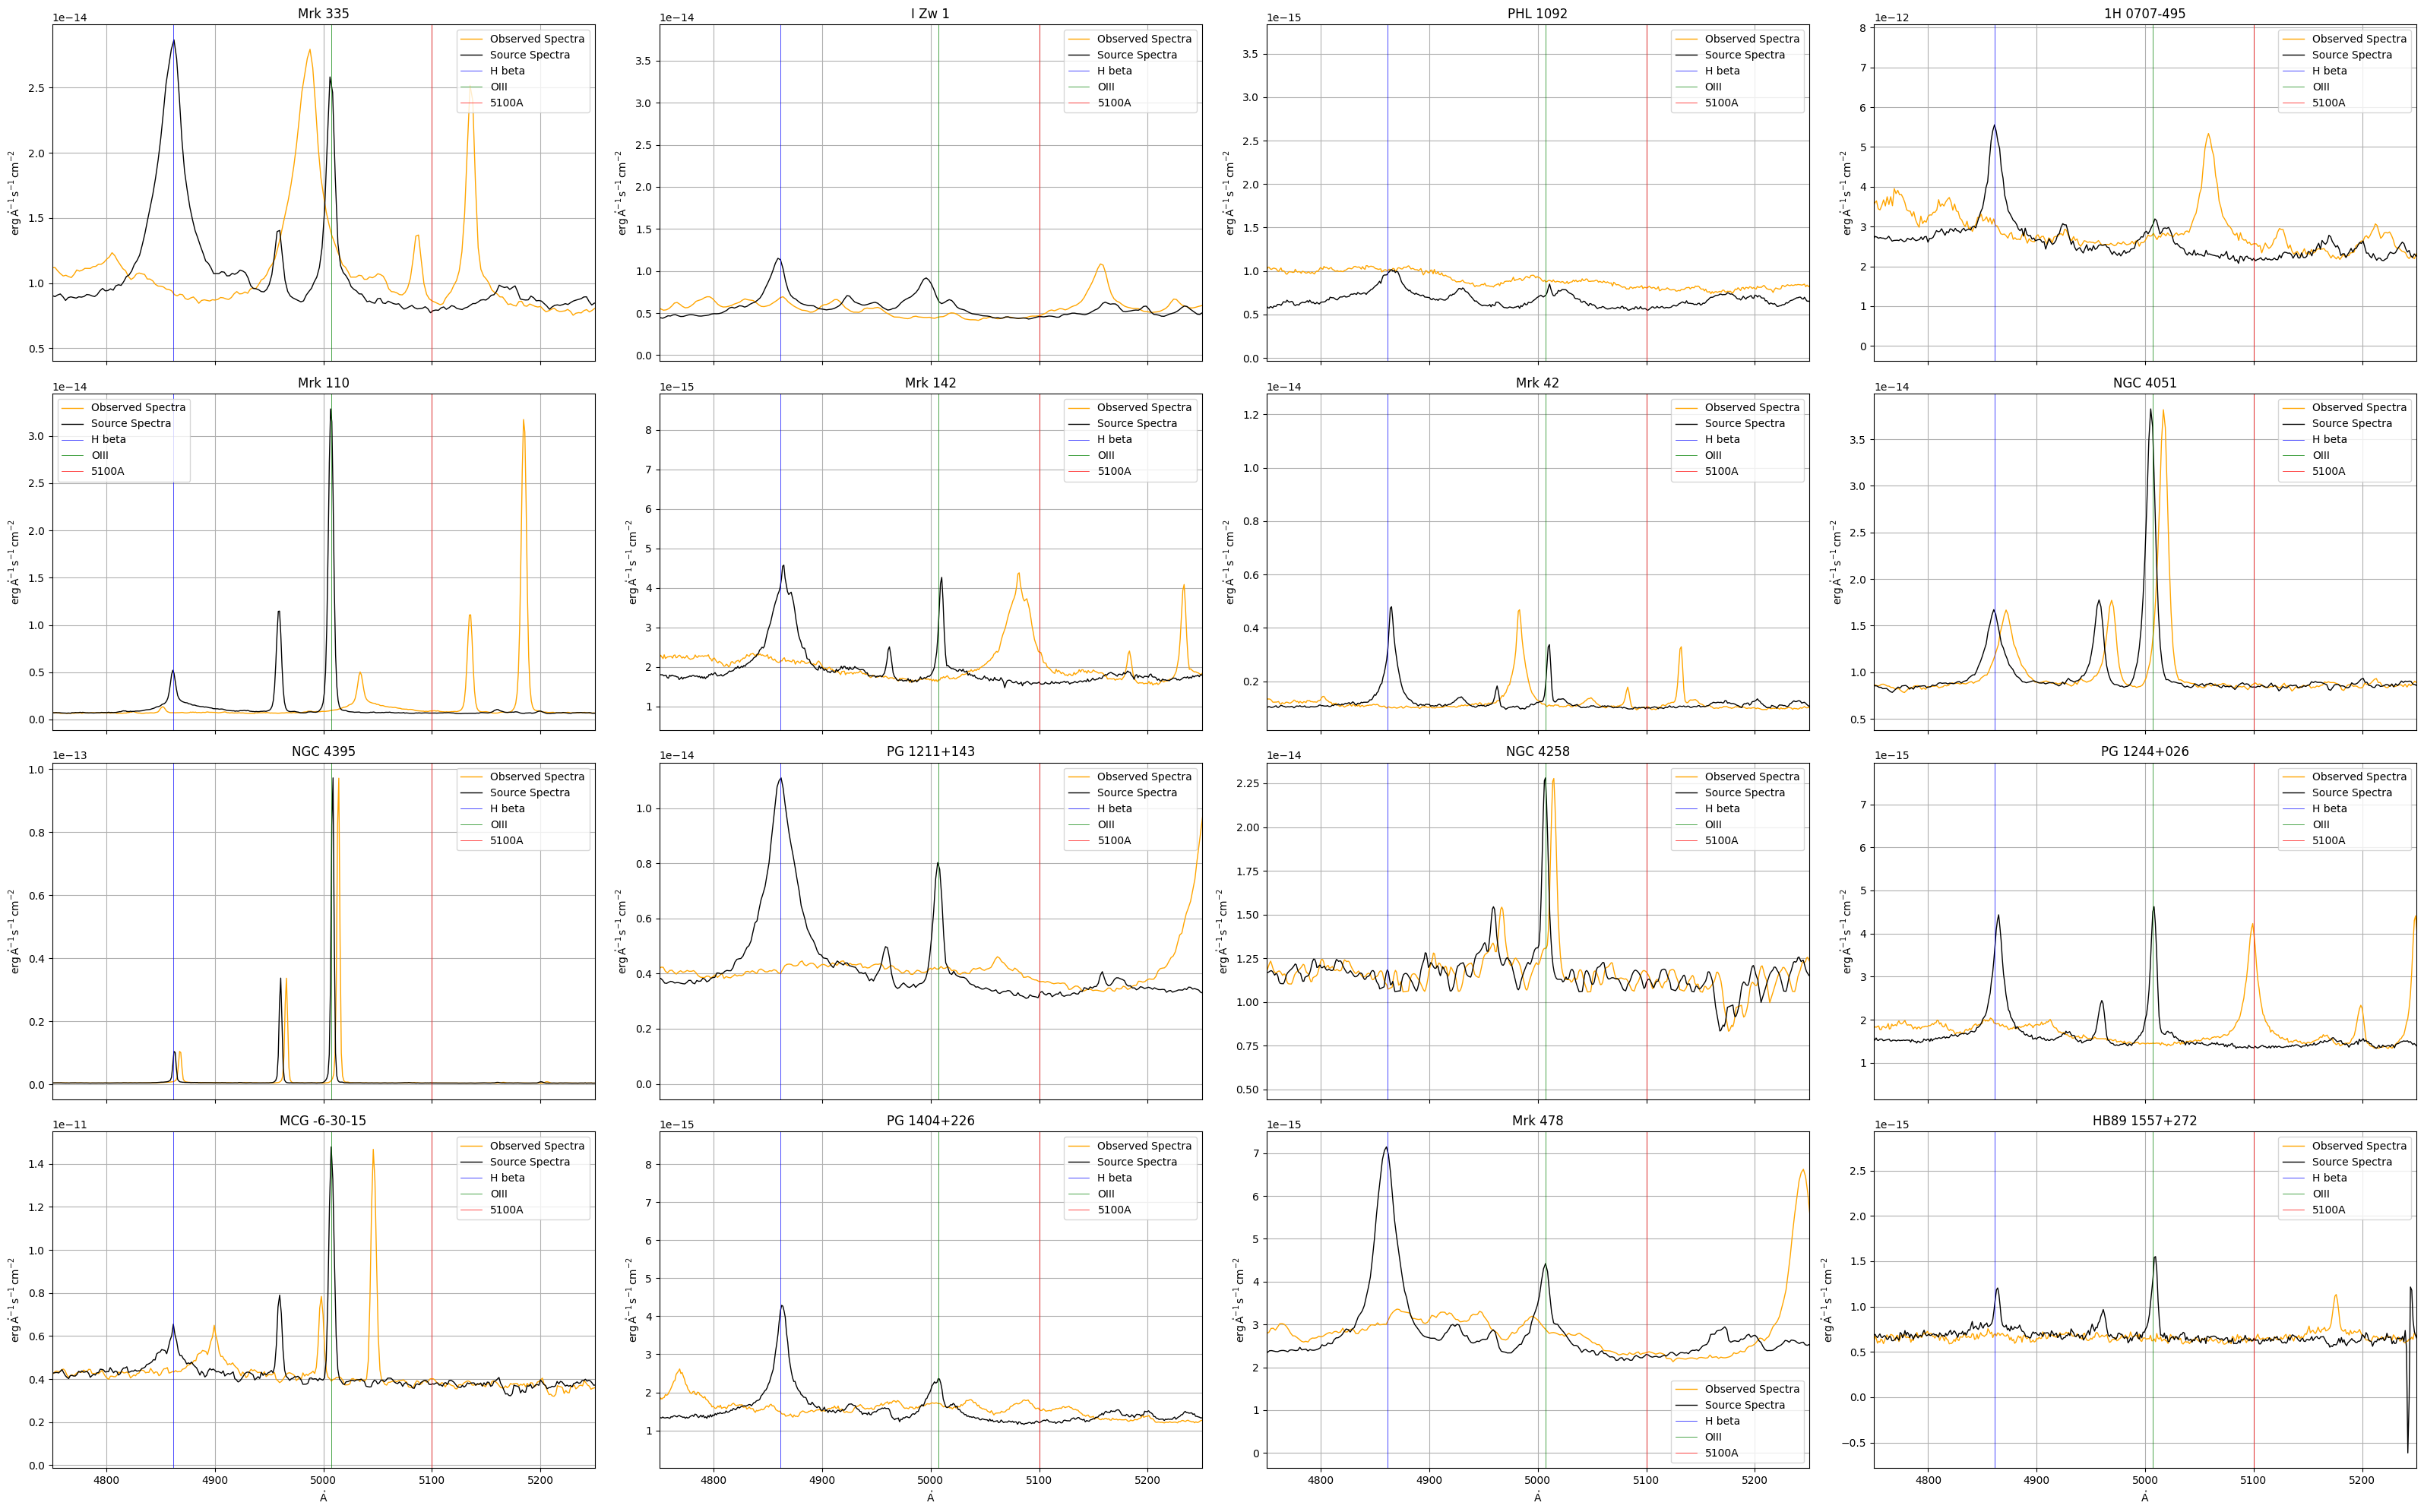

In [ ]:
from matplotlib import pyplot as plt

fig, ((ax0, ax1, ax2, ax3), (ax4, ax5, ax6, ax7), (ax8, ax9, ax10, ax11), (ax12, ax13, ax14, ax15)) = plt.subplots(4,4, figsize=(4*8, 4*5), sharex=True)

axs = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15]

lambda_hb = 4861.35 * u.AA

for i in np.arange(n):
  axs[i].plot(lambda_1[i], F_1[i].to(u.Unit('erg s-1 cm-2 AA-1')), label='Observed Spectra', color = "orange", linewidth=1)
  axs[i].plot(lambda_0[i], F_0[i].to(u.Unit('erg s-1 cm-2 AA-1')), label='Source Spectra', color = "black", linewidth=1)


  range = axs[i].get_ybound()
  axs[i].plot(np.array([lambda_hb.value, lambda_hb.value]) * u.AA, np.array([-1,1]) * (u.Unit('erg s-1 cm-2 AA-1')), label='H beta', color = "blue", linewidth = 0.5)
  axs[i].plot(np.array([5007, 5007]) * u.AA, np.array([-1,1]) * (u.Unit('erg s-1 cm-2 AA-1')), label='OIII', color = "green", linewidth = 0.5)
  axs[i].plot(np.array([5100, 5100]) * u.AA, np.array([-1,1]) * (u.Unit('erg s-1 cm-2 AA-1')), label='5100A', color = "red", linewidth = 0.5)
  axs[i].set_ybound(range)
  axs[i].set_xbound(4750*u.AA, 5250*u.AA)

  axs[i].set_title(Name[i])
  axs[i].grid()
  axs[i].legend()

plt.tight_layout()

## Calculation

### L(5100Å)

For continuum, we used the 5100 Å region as there are no major spectral line nearby. We fit a second-order weighted best fit curve for range (5010, 5190) Å with weight,

$w = (5190-λ) * (λ-5010)$


In [ ]:
lower_range = [[]] *n
upper_range = [[]] *n

for i in np.arange(n):
  temp = 0
  r=90

  for j in np.arange(0, len(L_0[i])):
    if lambda_0[i][j] >= (5100-r) *u.AA and temp == 0:
      lower_range[i] = j
      temp = 1
    if lambda_0[i][j] >= (5100+r) *u.AA and temp == 1:
      upper_range[i] = j
      break

In [ ]:
coefficients = [[]] *n
L_5100 = [[]] *n

for i in np.arange(n):
  x = lambda_0[i][lower_range[i]:upper_range[i]]
  y = L_0[i][lower_range[i]:upper_range[i]]

  x = x.value.tolist()
  y = y.value.tolist()

  x_ = []
  y_ = []


  for j in np.arange(len(x)):
    w = (upper_range[i]-lower_range[i]-j) * j
    for k in np.arange(w):
      x_.append(x[j])
      y_.append(y[j])

  x = x_
  y = y_

  coefficients[i] = np.polyfit(x, y, 2)

  L_5100[i] = np.poly1d(coefficients[i])(5100)

L_5100 = np.array(L_5100) * u.W

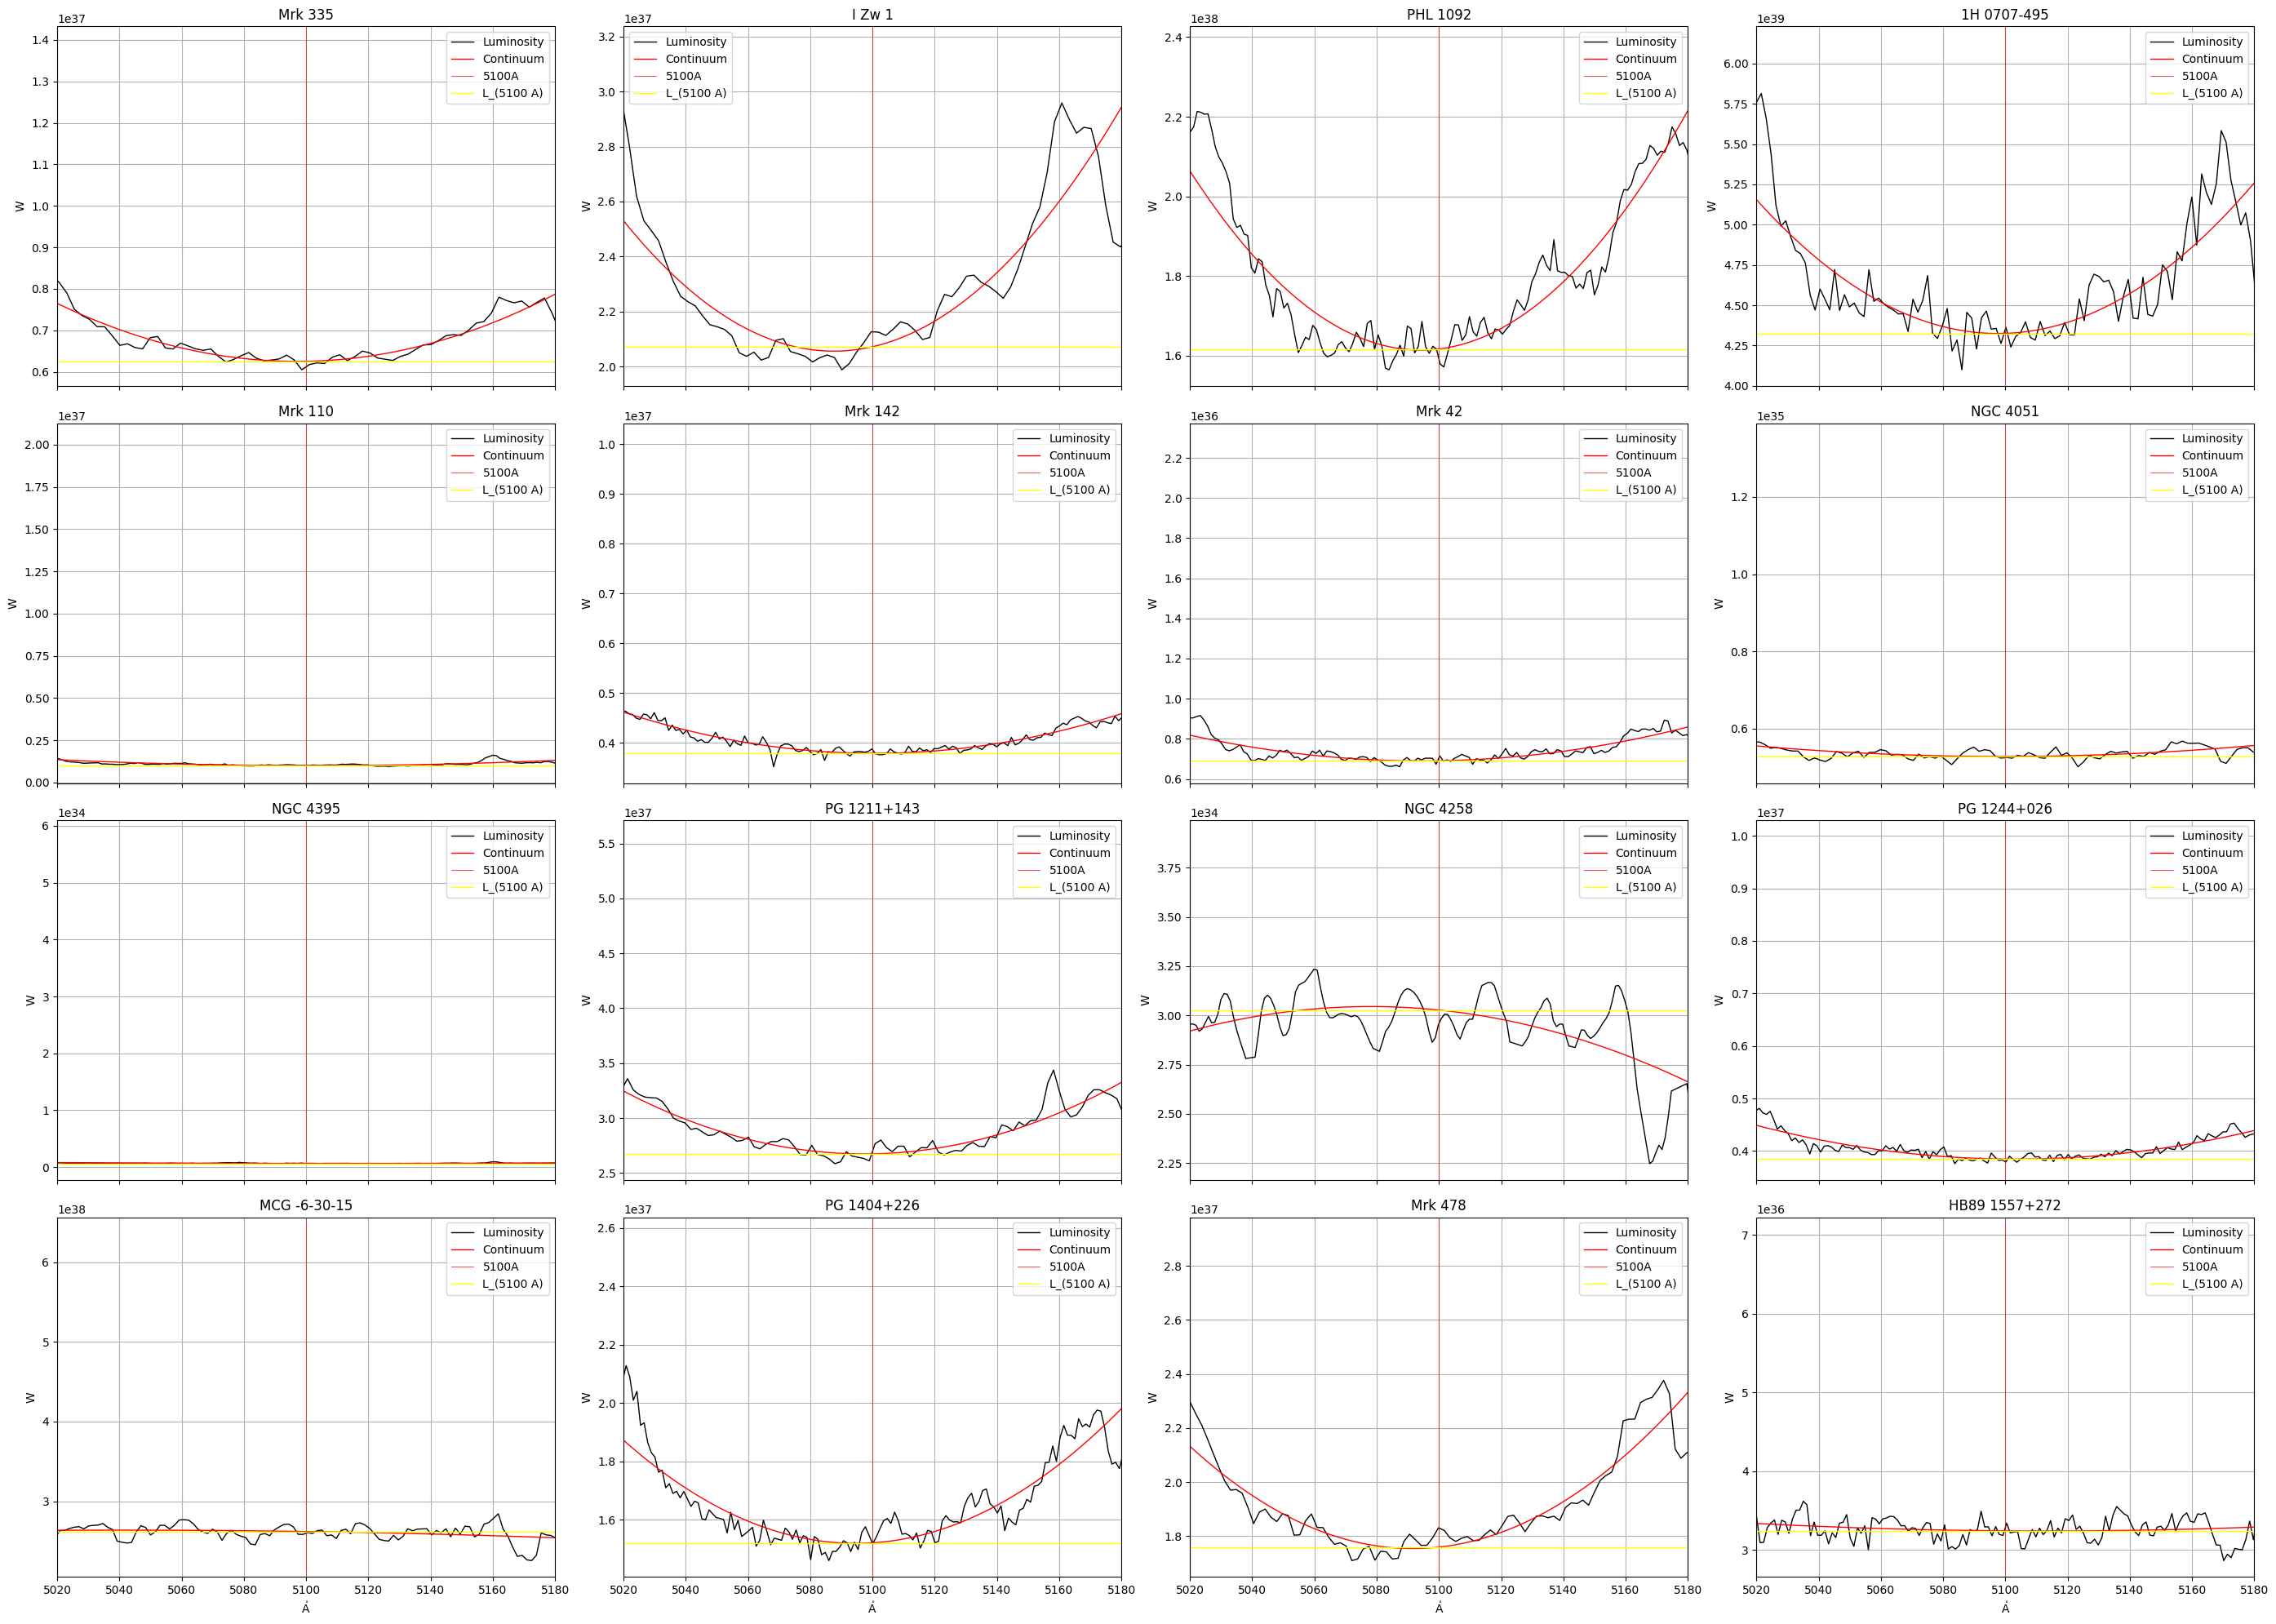

In [ ]:
from matplotlib import pyplot as plt

fig, ((ax0, ax1, ax2, ax3), (ax4, ax5, ax6, ax7), (ax8, ax9, ax10, ax11), (ax12, ax13, ax14, ax15)) = plt.subplots(4,4, figsize=(4*7, 4*5), sharex=True)

axs = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15]


for i in np.arange(n):
  axs[i].plot(lambda_0[i][lower_range[i]:upper_range[i]], L_0[i][lower_range[i]:upper_range[i]], label='Luminosity', color = "black", linewidth=1)

  x = np.linspace(lambda_0[i][lower_range[i]].value, lambda_0[i][upper_range[i]].value, 1000)

  axs[i].plot(x * u.AA, np.poly1d(coefficients[i])(x) * u.W, label='Continuum', color = 'red', linewidth = 1)


  range = axs[i].get_ybound()
  axs[i].plot(np.array([5100, 5100]) * u.AA, np.array([1e33,1e52])*L_0[i].unit, label='5100A', color = "red", linewidth = 0.5)
  axs[i].plot([lambda_0[i][lower_range[i]].value, lambda_0[i][upper_range[i]].value]* u.AA, np.array([L_5100[i].value, L_5100[i].value])*u.W, label='L_(5100 A)', color = "yellow", linewidth = 1)
  axs[i].set_ybound(range)
  axs[i].set_xbound(5020*u.AA, 5180 * u.AA)

  axs[i].set_title(Name[i])
  axs[i].grid()
  axs[i].legend()

plt.tight_layout()

### Mass

We assumed that the motion of broad-line clouds in elliptical orbit follows Kepler’s law of Orbital Motion. The Full Width Half Maxima of the Hydrogen β line arises from the Doppler shift of the spectrum due to the rotation of the BLR cloud around the black hole. We used this property to measure the rotation speed of the AGN ($v$).

$v = c \cdot \frac{FWHM}{λ}$

We measured the average radius of the BLR cloud ($R$) from using the radius-luminosity relation of the continuum luminosity at 5100 Å:

$\log(R) = -4.781 + 0.533 \cdot \log((L_{5100}))$

To account for the inclination of the rotational axis of the black hole, we included the virial factor ($f$). Its value can vary for different types of AGN spectra. Here, due to the spherical distribution of BLR mass, the value of the virial factor is 3/4 for all the AGNs we used.

In [ ]:
V = (FWHM).to(u.m/u.s)
R = 10**(-4.781 + (0.533*np.log10((L_5100.value)))) * u.m
f = 3/4

M_BH = (f * ((R*V**2)/const.G)).to(const.M_sun)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(0, 0, 'Mrk 335'),
  Text(1, 0, 'I Zw 1'),
  Text(2, 0, 'PHL 1092'),
  Text(3, 0, '1H 0707-495'),
  Text(4, 0, 'Mrk 110'),
  Text(5, 0, 'Mrk 142'),
  Text(6, 0, 'Mrk 42'),
  Text(7, 0, 'NGC 4051'),
  Text(8, 0, 'NGC 4395'),
  Text(9, 0, 'PG 1211+143'),
  Text(10, 0, 'NGC 4258'),
  Text(11, 0, 'PG 1244+026'),
  Text(12, 0, 'MCG -6-30-15'),
  Text(13, 0, 'PG 1404+226'),
  Text(14, 0, 'Mrk 478'),
  Text(15, 0, 'HB89 1557+272')])

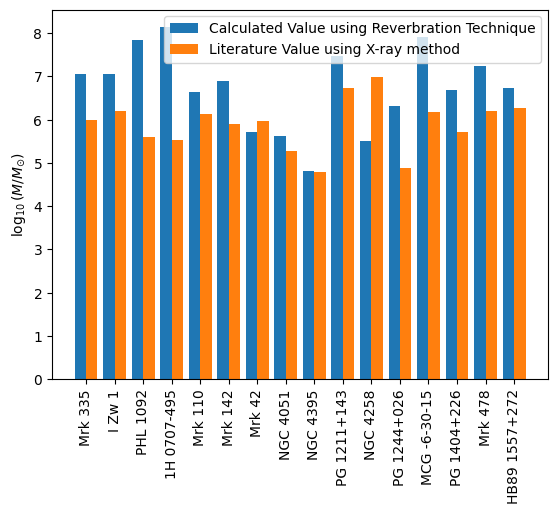

In [ ]:
from IPython.display import clear_output

!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

clear_output()

X_axis = np.arange(len(Name))

plt.bar(X_axis - 0.2, np.log10(M_BH.value), 0.4, label = 'Calculated Value using Reverbration Technique')
plt.bar(X_axis + 0.2, np.log10(mass.value), 0.4, label = 'Literature Value using X-ray method')
plt.ylabel(r'$\log_{10}(M/M_{\odot})$')

plt.legend()
plt.xticks(X_axis, Name)
plt.xticks(rotation = 90)

### Normalized $\sigma_{nxs}^2$

In [ ]:
sigma_normalized = sigma2_nxs/T

## Analysis (Ongoing)


[-1.10704969 -0.44921181]


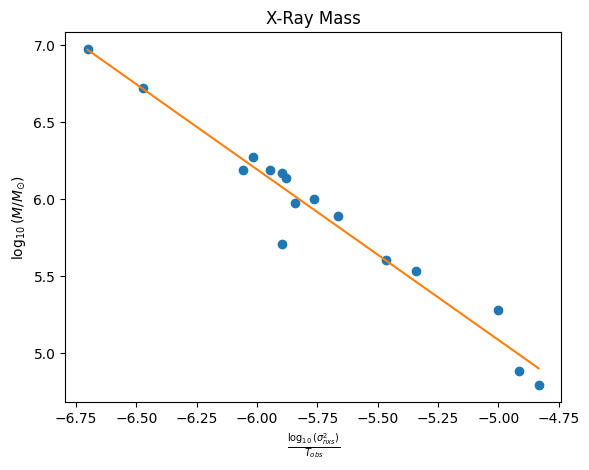

In [ ]:
order = 1

x = np.linspace(np.log10(sigma_normalized.min()), np.log10(sigma_normalized.max()), 100, endpoint = True)

plt.plot(np.log10(sigma_normalized), np.log10(mass.value), 'o')
plt.plot(x, np.poly1d(np.polyfit(np.log10(sigma_normalized), np.log10(mass.value), order))(x))
plt.ylabel(r'$\log_{10}(M/M_{\odot})$')
plt.xlabel(r'$\frac{\log_{10}(\sigma_{nxs}^2)}{T_{obs}}$')

plt.title("X-Ray Mass")

print(np.polyfit(np.log10(sigma_normalized), np.log10(mass.value), order))

[-0.92914015  4.00123602]


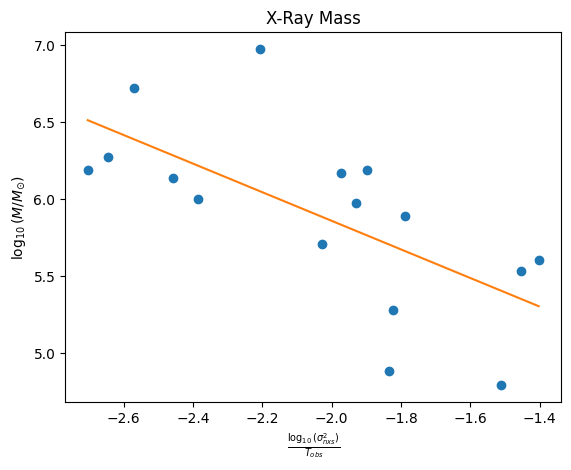

In [ ]:
order = 1

x = np.linspace(np.log10(sigma2_nxs.min()), np.log10(sigma2_nxs.max()), 100, endpoint = True)

plt.plot(np.log10(sigma2_nxs), np.log10(mass.value), 'o')
plt.plot(x, np.poly1d(np.polyfit(np.log10(sigma2_nxs), np.log10(mass.value), order))(x))
plt.ylabel(r'$\log_{10}(M/M_{\odot})$')
plt.xlabel(r'$\frac{\log_{10}(\sigma_{nxs}^2)}{T_{obs}}$')

plt.title("X-Ray Mass")

print(np.polyfit(np.log10(sigma2_nxs), np.log10(mass.value), order))

In [ ]:
[Name[x] for x in [0, 4, 7, 12]]

['Mrk 335', 'Mrk 110', 'NGC 4051', 'MCG -6-30-15']

In [ ]:
[np.log10(sigma_normalized[x]) for x in [0, 4, 7, 12]]

[-5.765856378792034,
 -5.879206117165289,
 -5.0005794456922334,
 -5.8973430952454295]

In [ ]:
from astropy.io import ascii
from astropy.table import Table

import numpy as np
from astropy import units as u
from astropy.visualization import quantity_support
quantity_support()
from astropy import constants as const

import pandas as pd
import requests
import io
import re
import builtins
details_link = 'https://drive.google.com/file/d/1tm_441GorL1J2435KGgjwY_GKwh4rtXJ/view?usp=drive_link'
extract_path = "/content/"

file_id = re.search(r'/d/([a-zA-Z0-9_-]+)', details_link).group(1)
url = f"https://drive.google.com/uc?id={file_id}&export=download"


table = ascii.read(url)
df = table.to_pandas()

print(df)

Name = np.array(df['Counterpart'])
Mass = 10**np.array(df['log(Mbh)'])
nxs100 = np.array(df['NXS100'])
nxs100_err = np.array(df['NXS100_Err'])
nxs1000 = pd.to_numeric(df['NXS1000']).to_numpy()
nxs1000_err = pd.to_numeric(df['NXS1000_Err']).to_numpy()
Type = np.array(df['type'])

       ID            SwiftID Counterpart     RAdeg    DEdeg       z  \
0       6  SWIFTJ0006.2+2012      Mrk335    1.5813  20.2029  0.0258   
1      16  SWIFTJ0029.2+1319  PG0026+129    7.3067  13.2675  0.1420   
2      34  SWIFTJ0051.6+2928      UGC524   12.8959  29.4013  0.0360   
3      36  SWIFTJ0051.9+1724     Mrk1148   12.9783  17.4329  0.0640   
4      39  SWIFTJ0054.9+2524  PG0052+251   13.7171  25.4272  0.1550   
..    ...                ...         ...       ...      ...     ...   
145  1176  SWIFTJ2256.5+0526     RBS1917  344.1521   5.4214  0.0660   
146  1182  SWIFTJ2303.3+0852     NGC7469  345.8151   8.8740  0.0163   
147  1183  SWIFTJ2304.8-0843      Mrk926  346.1811  -8.6857  0.0469   
148  1185  SWIFTJ2307.1+0433  PG2304+042  346.7621   4.5492  0.0420   
149  1189  SWIFTJ2318.9+0013     NGC7603  349.7359   0.2440  0.0295   

     dist(Mpc)  logNH  log(Mbh) method  log(L2-10)  log(L14-150)  eddratio  \
0        113.2  20.48   7.23011    Lit     43.2349       43.3380  0.0

In [ ]:
err_lim = 0.5
p_error100 = nxs100_err/nxs100
p_error1000 = nxs1000_err/nxs1000
error100 = nxs100_err/nxs100/np.log(10)
error1000 = nxs1000_err/nxs1000/np.log(10)

indices_to_delete = [Name.tolist().index(i[1]) for i in sorted([[p_error100[x], Name[x]] for x in builtins.range(len(Name))], key=lambda x: x[0]) if i[0] > err_lim] + [x for x in [Name.tolist().index(i[1]) for i in sorted([[p_error1000[x], Name[x]] for x in builtins.range(len(Name))], key=lambda x: x[0]) if i[0] > err_lim] if x not in [Name.tolist().index(i[1]) for i in sorted([[error100[x], Name[x]] for x in builtins.range(len(Name))], key=lambda x: x[0]) if i[0] > err_lim]]
Name = np.delete(Name, indices_to_delete)
Mass = np.delete(Mass, indices_to_delete)
nxs100 = np.delete(nxs100, indices_to_delete)
nxs100_err = np.delete(nxs100_err, indices_to_delete)
error100 = np.delete(error100, indices_to_delete)
error1000 = np.delete(error1000, indices_to_delete)
nxs1000 = np.delete(nxs1000, indices_to_delete)
nxs1000_err = np.delete(nxs1000_err, indices_to_delete)
Type = np.delete(Type, indices_to_delete)

In [ ]:
len(Name)

66

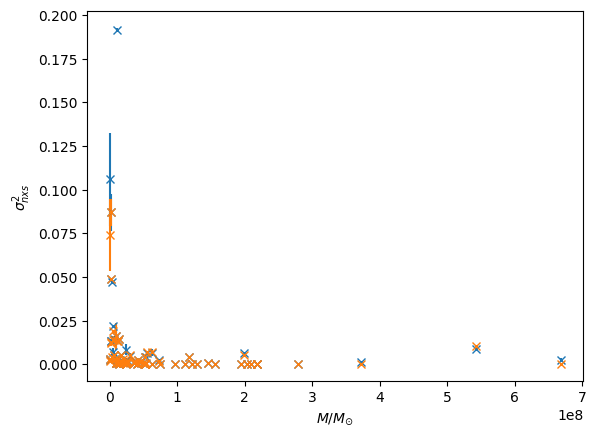

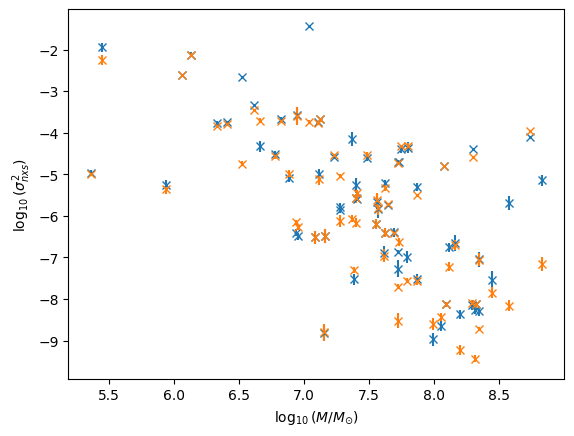

In [ ]:
import matplotlib.pyplot as plt

plt.errorbar(Mass, nxs100, yerr=nxs100_err, fmt = 'x')
plt.errorbar(Mass, nxs1000, yerr=nxs1000_err, fmt = 'x')
plt.ylabel(r'$\sigma_{nxs}^2$')
plt.xlabel(r'$M/M_{\odot}$')
plt.show()

plt.errorbar(np.log10(Mass), np.log10(nxs100**2), yerr=nxs100_err/nxs100/np.log(10), fmt = 'x')
plt.errorbar(np.log10(Mass), np.log10(nxs1000**2), yerr=nxs1000_err/nxs1000/np.log(10), fmt = 'x')
plt.ylabel(r'$\log_{10}(\sigma_{nxs}^2)$')
plt.xlabel(r'$\log_{10}(M/M_{\odot})$')
plt.show()

[-0.486675    6.07604853]


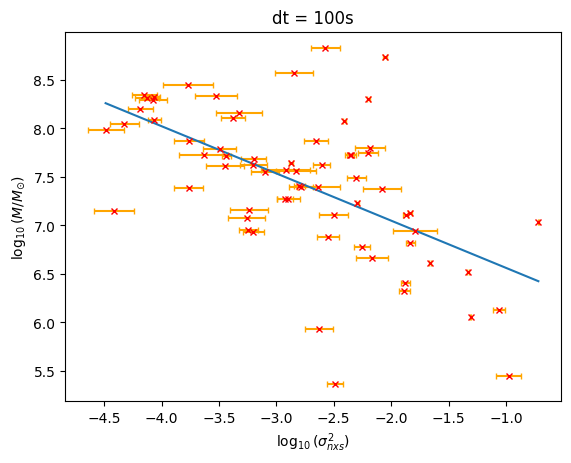

[-0.53576289  5.86604884]


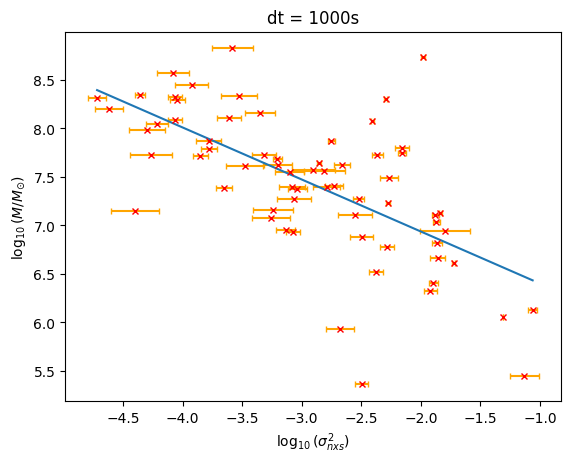

In [ ]:
X = np.log10(nxs100)
Y = np.log10(Mass)
err = error100

x = np.linspace(X.min(), X.max(), 100, endpoint = True)

plt.errorbar(X, Y, xerr=err, fmt='rx', markersize=4, capsize=2, ecolor='orange')
plt.plot(x, np.poly1d(np.polyfit(X, Y, 1))(x))
plt.ylabel(r'$\log_{10}(M/M_{\odot})$')
plt.xlabel(r'$\log_{10}(\sigma_{nxs}^2)$')
plt.title("dt = 100s")

print(np.polyfit(X, Y, 1))
plt.show()

X = np.log10(nxs1000)
Y = np.log10(Mass)
err = error1000

x = np.linspace(X.min(), X.max(), 100, endpoint = True)

plt.errorbar(X, Y, xerr=err, fmt='rx', markersize=4, capsize=2, ecolor='orange')
plt.plot(x, np.poly1d(np.polyfit(X, Y, 1))(x))
plt.ylabel(r'$\log_{10}(M/M_{\odot})$')
plt.xlabel(r'$\log_{10}(\sigma_{nxs}^2)$')
plt.title("dt = 1000s")

print(np.polyfit(X, Y, 1))
plt.show()

## Acknowledgement

## References

[1]